# Tow-Based Discontinuous Composite (TBDC) property predictor
This code is written for an MSc research project at Imperial College London

## Mount drive

In [1]:
# Data to be imported from google drive
from google.colab import drive
drive.mount('/content/drive')

# Set path for drive with datasets
drive_path ="/content/drive/MyDrive/Individual_project_ICL"

Mounted at /content/drive


## Imports and installs

In [2]:
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas

In [3]:
import os
import random
import time
import math
import datetime
import shutil
import json

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Import data


In [4]:
if 'data' not in os.listdir():
  !cp {drive_path+"/Data/Unnotched_TBDC_2022.zip"} .
  !unzip -q 'Unnotched_TBDC_2022.zip' -d data
  !rm 'Unnotched_TBDC_2022.zip'

Verify that data is imported correctly

In [5]:
def loadSample(path = str):
  '''
  Imports data in csv and formats into a tensor
  '''
  # Read sample csv data
  sample = pd.read_csv(path)
  headers = sample.columns.values.tolist()
  values = np.array(sample)

  coords = [[x for x in values[:,1][y].split(' ') if x] for y in range(len(values[:,1]))] # Split coordinates by delimiter (space)
  coords = [np.char.strip(x, '[') for x in coords] # Coordinate output from abaqus has leading "["
  coords = [[x for x in coords[y] if x] for y in range(len(values[:,1]))] # remove empty array elements
  coords = np.array([[float(x) for x in coords[y][0:2]] for y in range(len(values[:,1]))]) # Take 2d coordinates and convert to float


  values = np.column_stack((values[:,0],coords,values[:,2:])).astype(float) # Create a new values vector which contains the coordinates
  # values = values.astype(np.float)

  headers = np.concatenate(([[headers[0],'x_coord','y_coord'],headers[2:]])) # rectify the headers to include x and y coordinates separately

  return headers, values




['label' 'x_coord' 'y_coord' 'e11' 'e22' 'e12' 'S11' 'S22' 'S12' 'SMises'
 'FI' 'E11' 'E22' 'E12']
[[ 1.00000000e+00  2.37500000e+01  6.77454500e+01 ...  4.23866914e+04
   4.32930625e+04  2.06601074e+04]
 [ 2.00000000e+00  2.12500000e+01  6.77454500e+01 ...  4.19203984e+04
   4.16220039e+04  2.13048340e+04]
 [ 3.00000000e+00  1.87500000e+01  6.77454500e+01 ...  4.14541055e+04
   3.99509414e+04  2.19495605e+04]
 ...
 [ 1.09800000e+03 -1.87500000e+01 -6.77454500e+01 ...  5.58986875e+04
   4.46753555e+04  1.70089414e+04]
 [ 1.09900000e+03 -2.12500000e+01 -6.77454500e+01 ...  5.65772109e+04
   4.28433398e+04  1.74488691e+04]
 [ 1.10000000e+03 -2.37500000e+01 -6.77454500e+01 ...  5.72557305e+04
   4.10113242e+04  1.78887988e+04]]


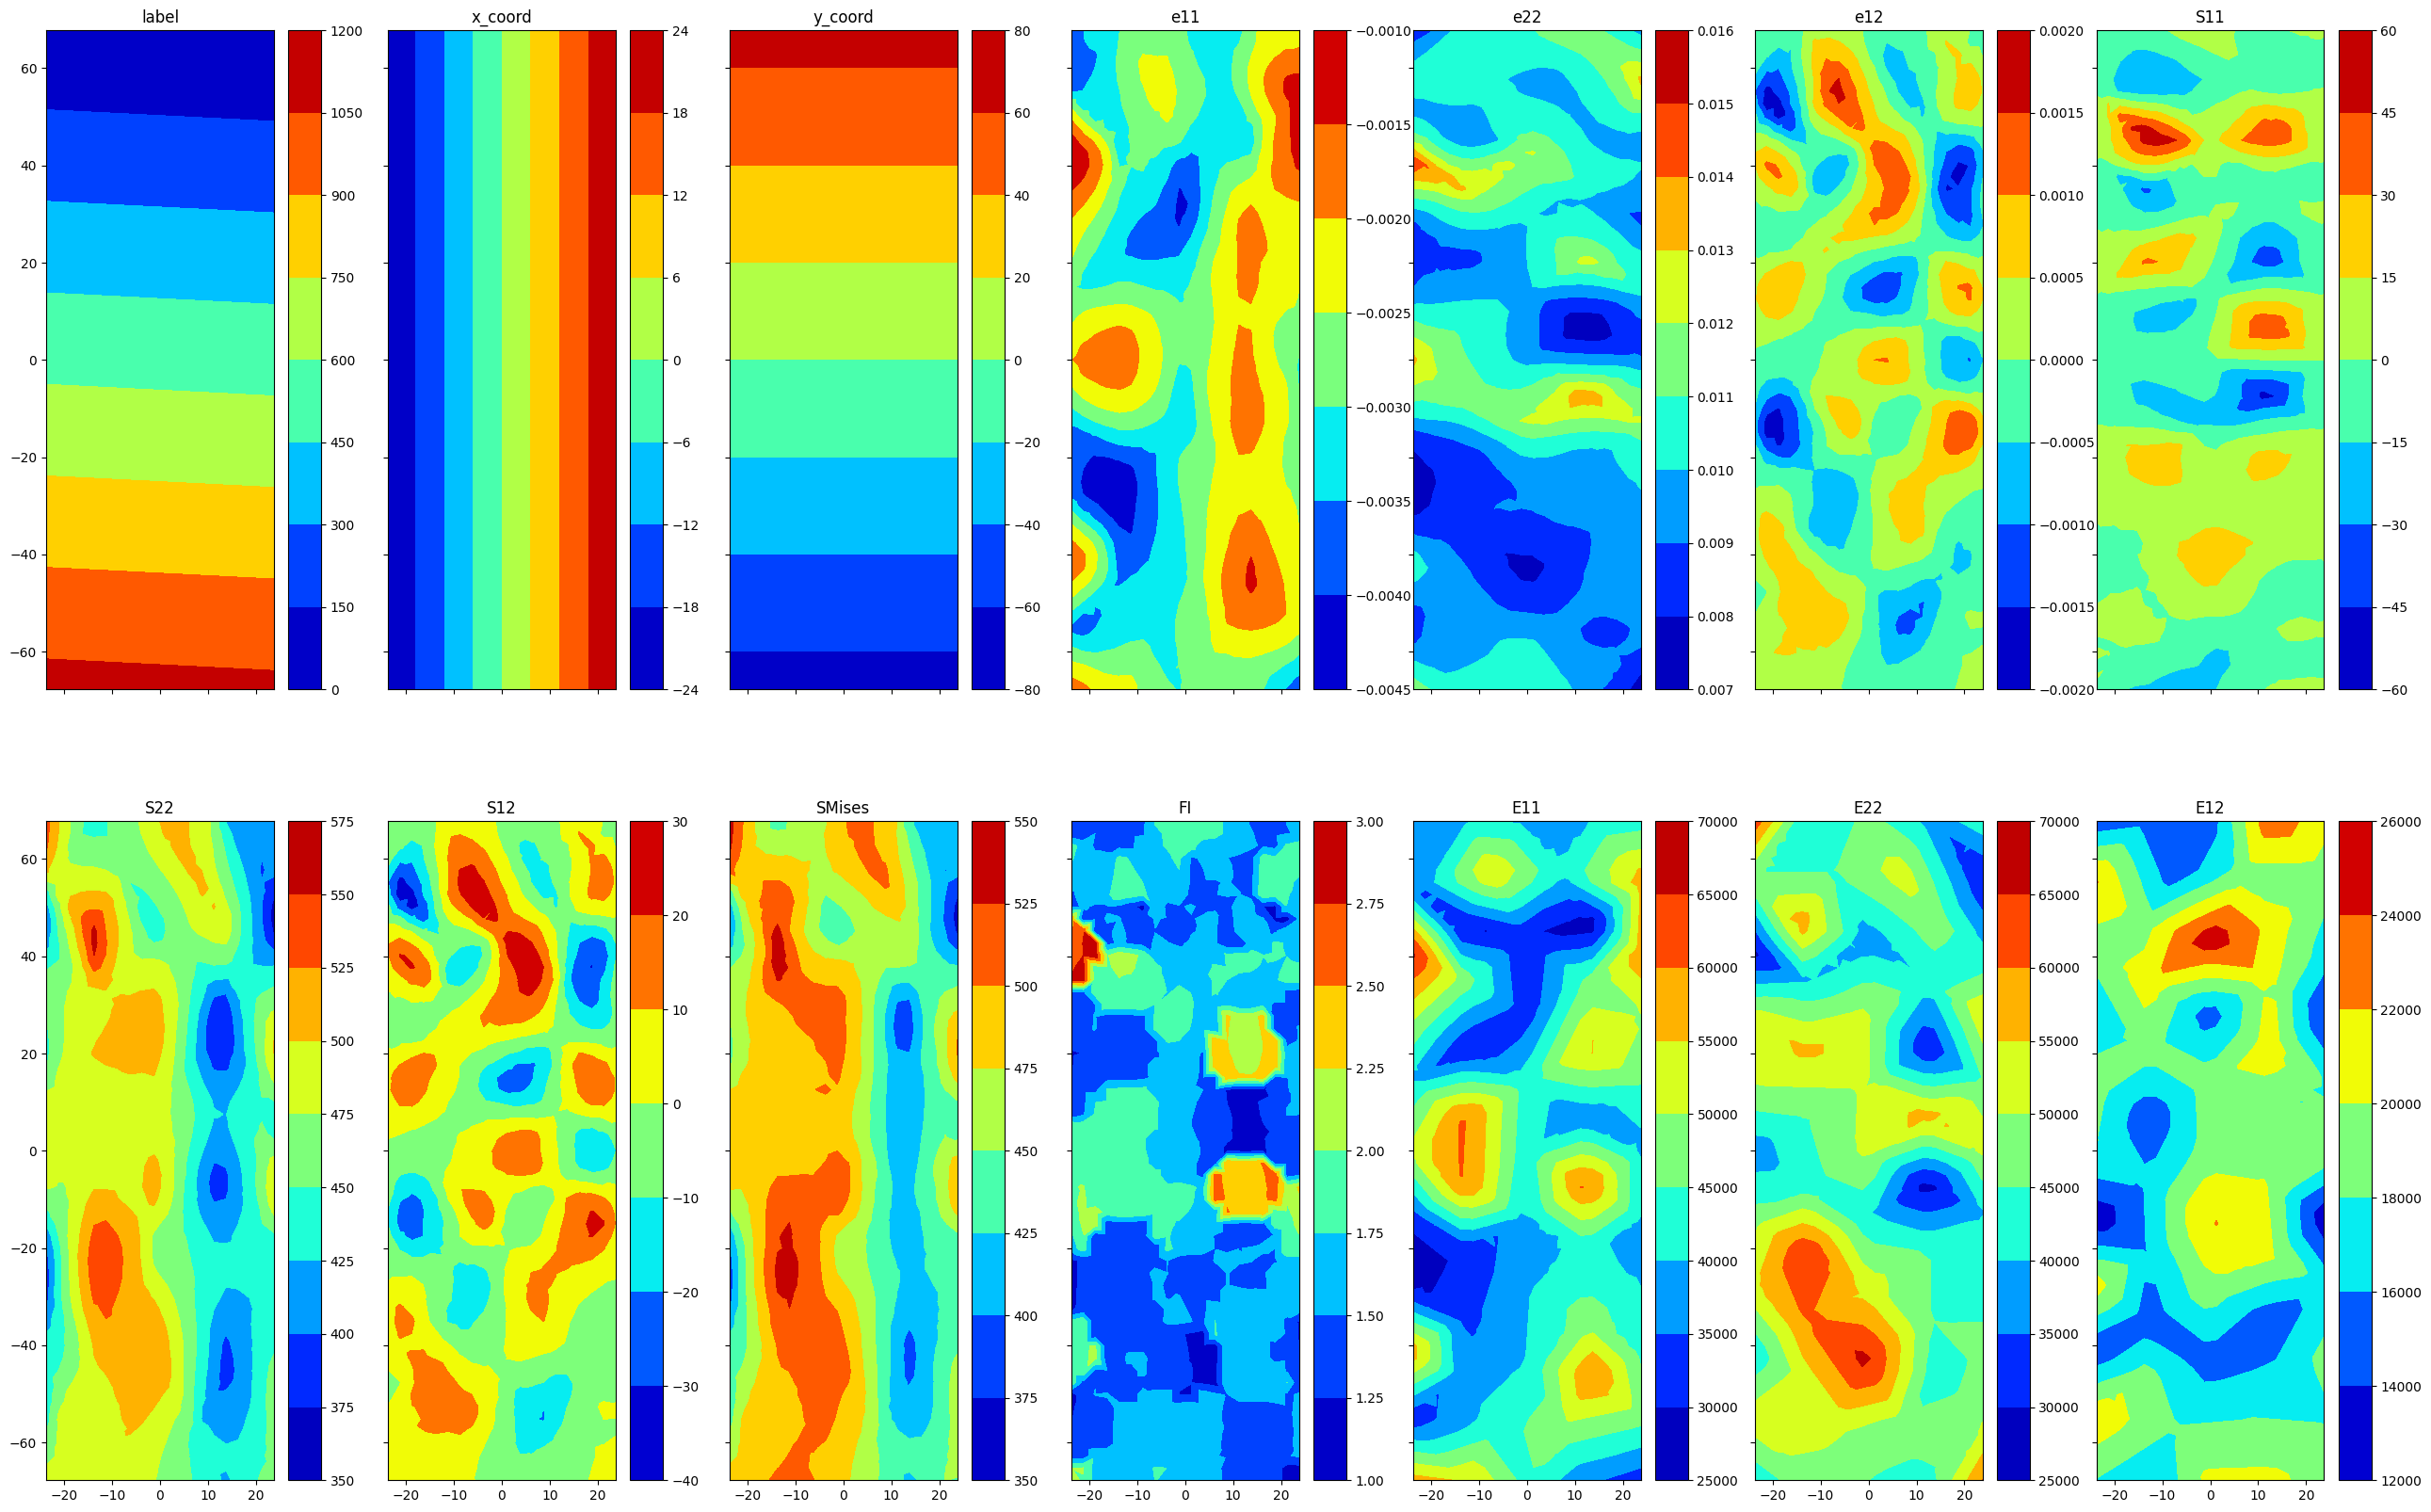

In [51]:
testHeaders, testSample = loadSample('data/Unnotched_TBDC_2022_0.csv')
print(testHeaders)
print(testSample)
import matplotlib.tri as tri
import matplotlib.ticker as plticker

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(testSample[:,1], testSample[:,2])
min_radius = 0.25
# Mask off unwanted triangles.
triang.set_mask(np.hypot(testSample[:,1][triang.triangles].mean(axis=1), testSample[:,2][triang.triangles].mean(axis=1)) < min_radius)

# Plot triangulation map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  tcf = ax.tricontourf(triang, testSample[:,i], cmap = 'jet')
  fig.colorbar(tcf)
  ax.set_title(testHeaders[i])


Alternative method without triangulation but reshaping into 2d matrix

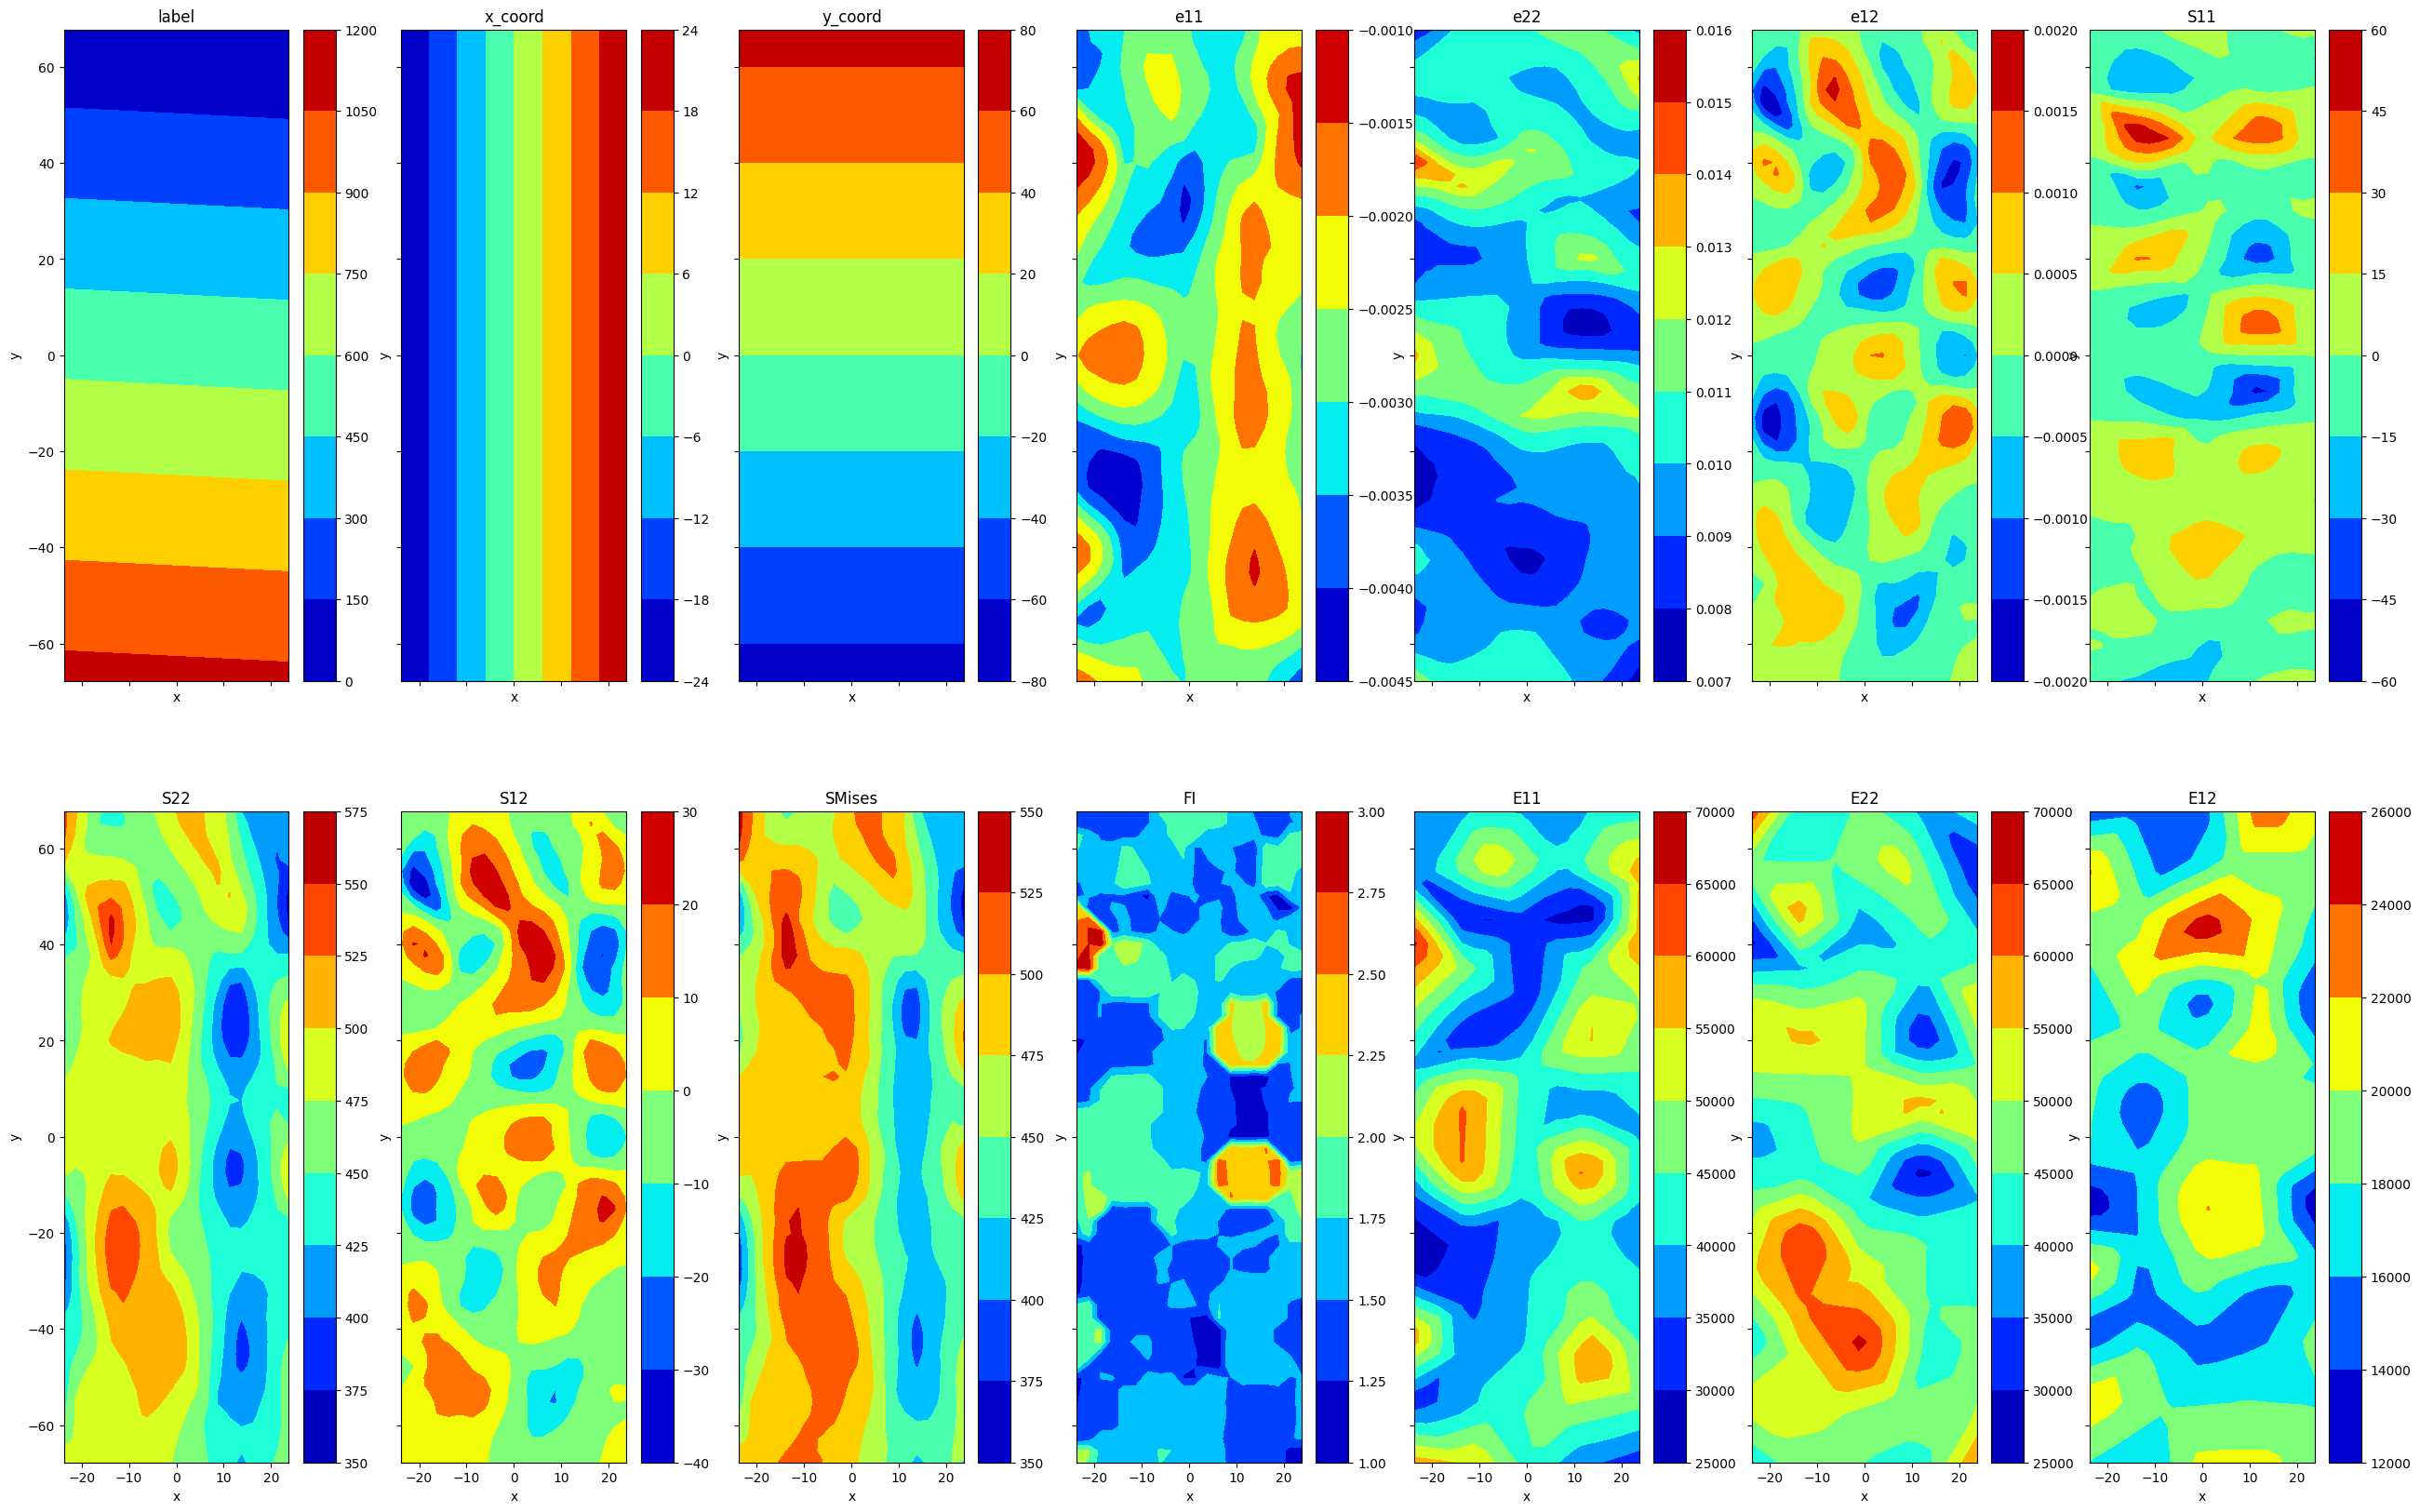

In [49]:
# Shape of specimen is 20x55
testReshaped = testSample.reshape(55,20,14)

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Plot  map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  CS = ax.contourf(testReshaped[:,:,1],testReshaped[:,:,2],testReshaped[:,:,i], cmap = 'jet')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(testHeaders[i])
  fig.colorbar(CS)

# Computing correlation stats of vertical stiffness and strains

In [24]:
# explicit function to normalize array
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

E22 = testSample[:,12] # Stiffness
e22 = testSample[:,4] # Strain
FI = testSample[:,10]

E22norm = normalize_2d(E22)
e22norm = normalize_2d(e22)
FInorm = normalize_2d(FI)

In [35]:
sortIdx = np.rec.fromarrays([E22, e22, FI]) # Sort values based on ascending E22
sortIdx.sort()

E22sort = sortIdx.f0
e22sort = sortIdx.f1
FIsort = sortIdx.f2

cov = np.cov(E22norm,e22norm)
cov2 = np.cov(E22norm,FInorm)


In [36]:
cov2

array([[ 1.68189273e-05, -1.32442297e-05],
       [-1.32442297e-05,  2.94815079e-05]])

Text(0, 0.5, 'e22')

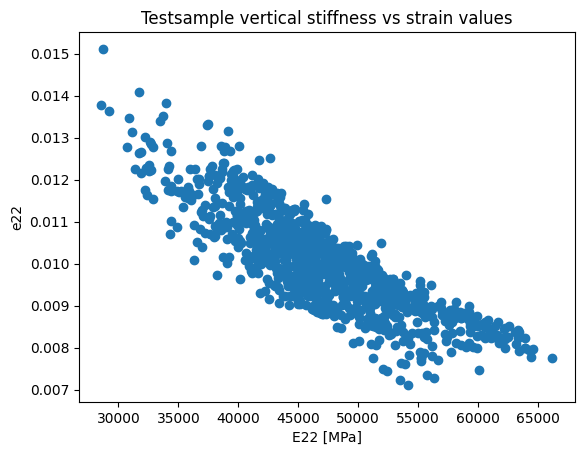

In [21]:
fig, axs = plt.subplots()
plt.scatter(E22,e22)
plt.title('Test sample vertical stiffness vs strain values')
plt.xlabel('E22 [MPa]')
plt.ylabel('e22')

Text(0, 0.5, 'FI')

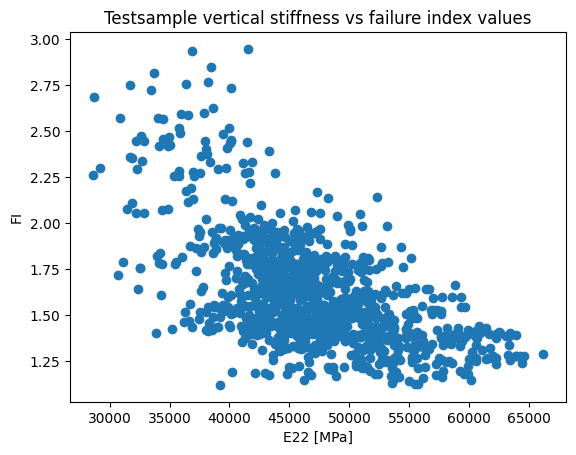

In [26]:
fig, axs = plt.subplots()
plt.scatter(E22,FI)
plt.title('Test sample vertical stiffness vs failure index values')
plt.xlabel('E22 [MPa]')
plt.ylabel('FI')